<a href="https://colab.research.google.com/github/j-hermansen/dog-breed-identification/blob/main/dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to end multi-class Dog breed classification

This notebook builds an end-to-end multi-class image classifier using Tensorflow 2.0 and Tensorflow Hub.


## 1. Problem
Identifying the breed of  a dog given an image of a dog.

When I'm sitting at the cafe and I take a image of a dog, I want to know what breed the dog is.


## 2. Data
The data we're using is from a competition on identifying dog breeds on Kaggle.

https://www.kaggle.com/competitions/dog-breed-identification/data


## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation


## 4. Features
Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes)
* There are around 10 000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images has no labels, because these will be predicted)

In [1]:
# Unzip the uploaded data into Google Drive
# !unzip "drive/MyDrive/data/dog-breed-identification.zip" -d "drive/MyDrive/data/"  # use '!' to run command line keywords

## Get out workspace ready

* Import Tensorflow 2.x ✅
* Import Tensorflow Hub ✅
* Make sure we're using a GPU ✅

In [2]:
# Import necessary tools
import tensorflow_hub as hub
import tensorflow as tf
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.12.0
TF Hub version: 0.13.0
GPU available


## Getting out data ready (turning into Tensors)

With all machine learning models, out data has to be in numerical format. So thats what we'll be doint first. Turning out images into Tensors (numerical representations)

Let's start by accessing out data and checking out the labels.

In [3]:
# Checking the labels of out data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/data/labels.csv")

print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: >

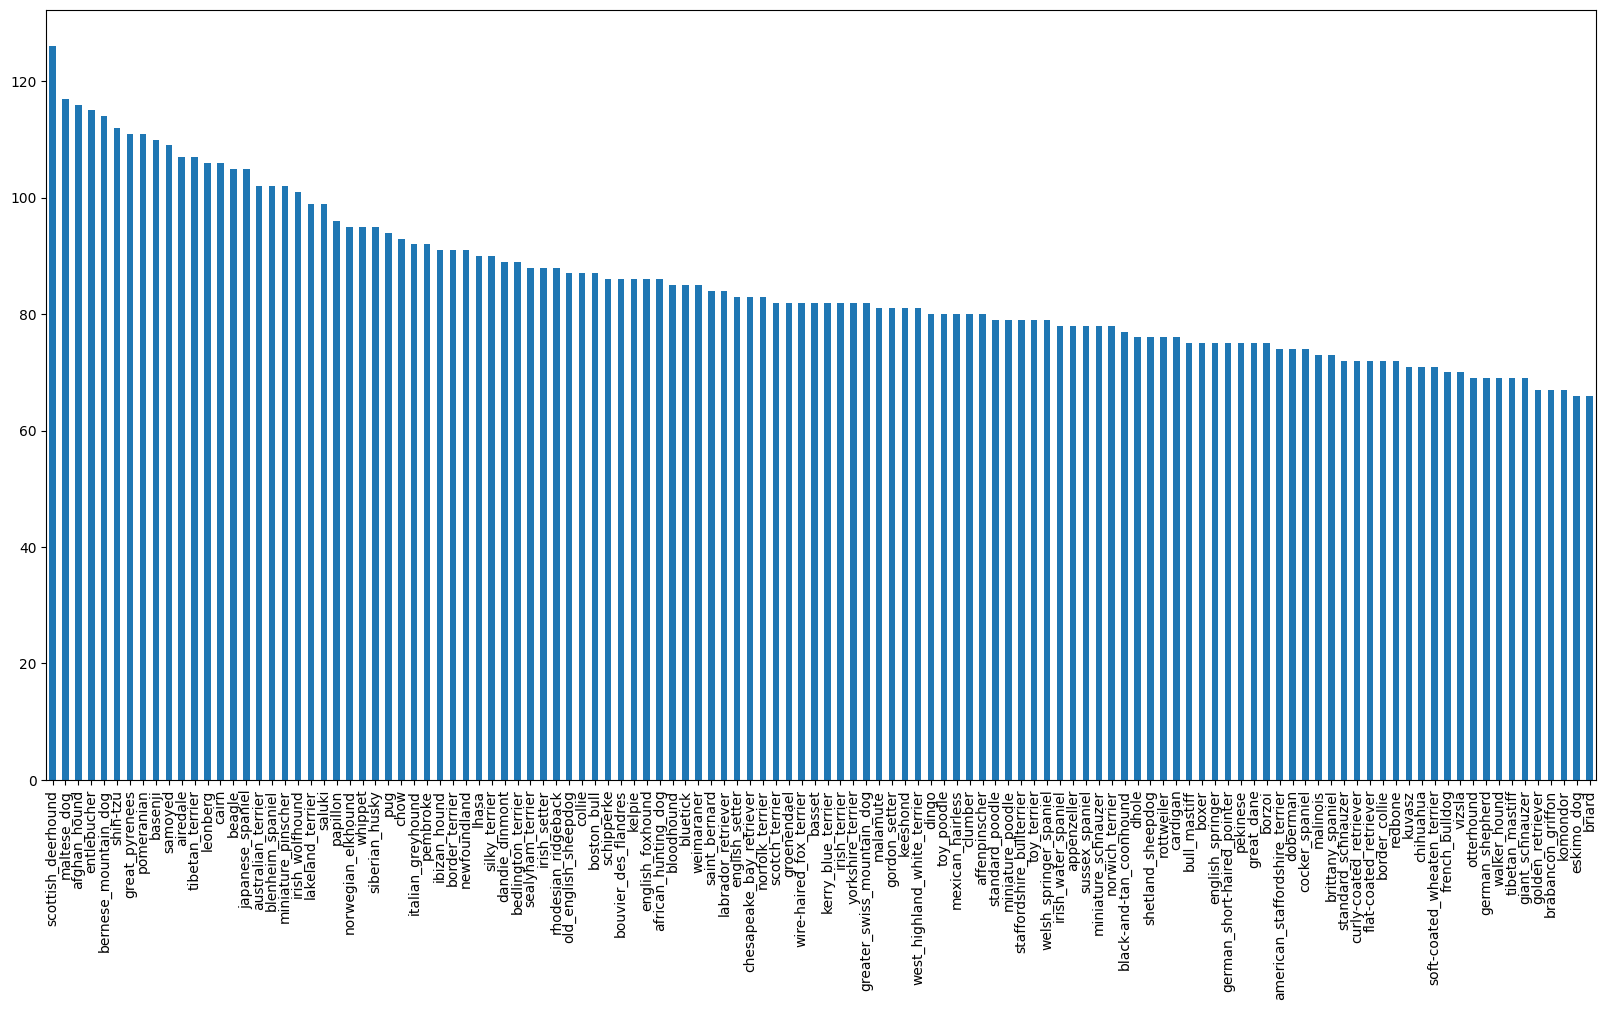

In [4]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [5]:
labels_csv["breed"].value_counts().median()

82.0

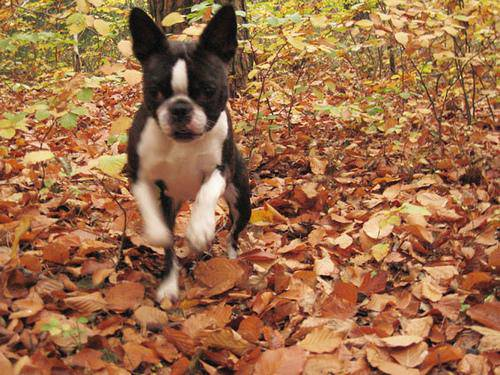

In [6]:
#Let's view an image
from IPython.display import Image
Image("drive/MyDrive/data/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Let's get a list fo all our image file pathnames.

In [7]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [9]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/data/train/")) == len(filenames):
  print("Filenames match actual amount of files.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files.


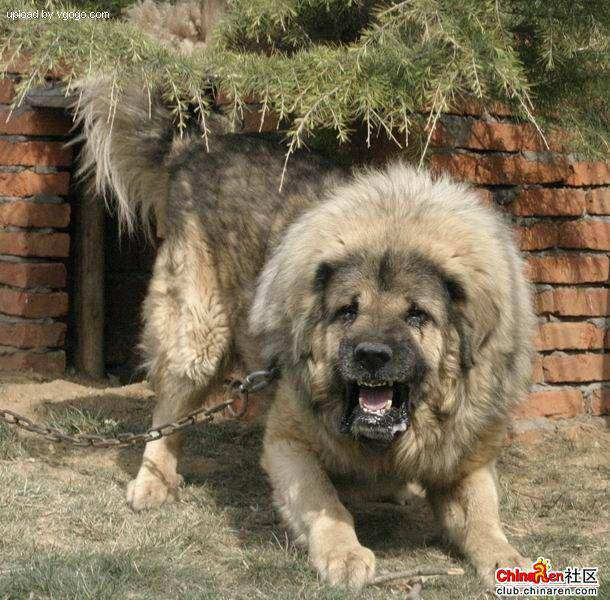

In [10]:
# One more check
Image(filenames[9000])

In [11]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels

In [12]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # does the same thing as .to_numpy() above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [13]:
len(labels)

10222

In [14]:
# See if number of labels matches the numbers of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames.")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames.


In [15]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [16]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [17]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels)

10222

In [18]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 ehere the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [19]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating out own validations et
Since the dataset from Kaggle doesn't come with a validation set, we have to create our own.

In [20]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [21]:
len(filenames)

10222

We're going to start of experimenting with ~1000 images and increase as needed.

In [22]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [23]:
# Let's split out data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of totoal size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [24]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/data/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/data/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, 

## Preprocessing Images (turning images into Tensors)

To preprocess out images into Tensors we're going to write a fucntion which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modied `image`

Before we do, let's see what importing an image looks like.

In [25]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [26]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [27]:
# Turn image into a Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen that an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize out iamge (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224)
6. Return the modied `image`

In [28]:
# Deæfine image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """

  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to out desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning out data into batches

Why turning out data into batches?

Let's say you're trying to process 10,000+ imagesin one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need out data in the form of Tensor tuples which look like this:
`(image, label)`



In [29]:
# Create a simple function to return a ttuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)

  return image, label

In [30]:
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [31]:
X[42]

'drive/MyDrive/data/train/011e06760794850c40f23d6426c40774.jpg'

Now we've got a way to turn out data into tuples of Tensors in the from: `(image, label)`, let's make a function to turn all of out data (`X` & `y`) into batches!

In [32]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data otu of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")

    data = tf.data.Dataser.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Create training data batches...")

    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turn the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch

In [33]:
# Create traning and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Create training data batches...
Creating validation data batches...


In [34]:
# Check out the different attributes of out data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them

In [40]:
import matplotlib.pyplot as plt

# Create a function for viewing image sin a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """

  # Setup the figure
  plt.figure(figsize=(10, 10))

  # Loop thorugh 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)

    # Display an image
    plt.imshow(images[i])

    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])

    # Turn the grid lines off
    plt.axis("off")

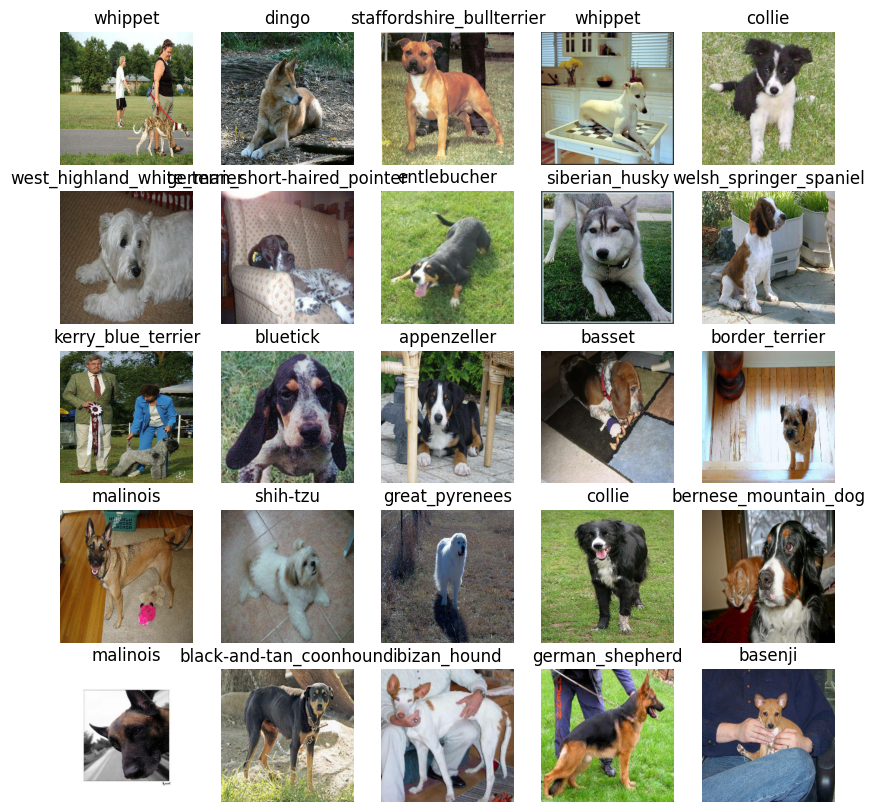

In [41]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

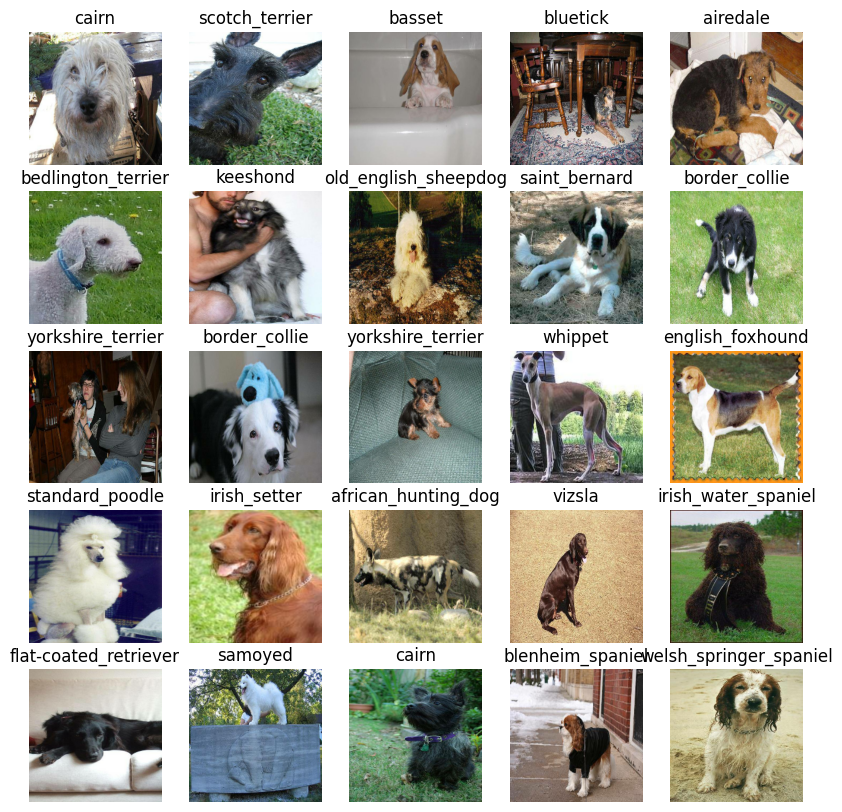

In [42]:
# Now let's visualize out validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)